# Toy Example

## Settings for i.i.d case

\begin{align}
    S_{0}&\sim Bernoulli(0.5)\\
    M_{t}&\sim Bernoulli(expit(1.0-1.5S_{t}+2.5A_{t}))\\
    R_{t}&\sim Bernoulli(expit(1.0+2S_{t}-1A_{t}-2.5M_{t}))\\
    S_{t+1}&\sim Bernoulli(.2)\\
    \pi_{b}&\sim Bernoulli(expit(1.0-2.0S{t}))\\
    \pi_{e}&\sim Bernoulli(expit(1.5+1.0S{t}))\\
    a_0&=0
\end{align}

In [1]:
        from scipy.special import expit
        pa = 1.0-2
        #pa = 1.0
        pa = expit(pa)
        pa

0.2689414213699951

## True Q & True etas

In [2]:
def target_policy(state, action = None, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        pa = expit(1.5 + 1.0 * state1)
        if action is not None:
            action1 = np.copy(action).flatten()
            pa = pa * action1 + (1-pa) * (1-action1)
    else:
        pa = 1.5 + 1.0 * np.sum(state)
        pa = expit(pa)
        pa = np.random.binomial(n=1, p=pa, size=1)
    return pa
    
def toy_sa2mediator_model(state, action, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        action1 = np.copy(action).flatten()
        pm =  1.0 - 1.5 * state1 + 2.5 * action1
        pm = expit(pm)
    else:
        pm = 1.0 - 1.5 * state + 2.5 * action
        pm = expit(pm)
        pm = np.random.binomial(n=1, p=pm, size=1)
    return pm

def pmlearner(state, action, mediator):
    pm_one = toy_sa2mediator_model(state, action=action, matrix_based = True).flatten() 
    pm = mediator * pm_one + (1 - mediator) * (1 - pm_one)
    return pm

def control_policy(state = None, action=None, get_a = False, matrix_based=False):
    # fixed policy with fixed action 0
    if get_a:
        action_value = 0
        
    elif matrix_based:
        action1 = np.copy(action).flatten()
        action_value = 1 - action1 ###for a0 = 0 only
        
    else:
        if action is None:
            action_value = 0 
        else:
            if action == 0:
                action_value = 1
            else:
                action_value = 0
    return action_value

def toy_sam2reward_model(state, action, mediator, random = None, matrix_based = False):
        if matrix_based:
            #print("matrix")
            state1 = np.copy(state).flatten()
            action1 = np.copy(action).flatten()
            mediator1 = np.copy(mediator).flatten()
            rmean = 1.0 + 2 * state1 - 1 * action1 -  2.5 * mediator1
            #rmean = 1.0 * np.ones(shape = state1.shape[0])
            rmean = expit(rmean)
            if random is None:
                rmean *= 10
                reward = rmean
            else:
                print("wrong")
        else:
            rmean = 1.0 + 2 * state - 1 * action -  2.5 * mediator
            #rmean = 1.0
            rmean = expit(rmean)
            if random:
                reward = np.random.binomial(n=1, p=rmean, size=1) * 10
            else:
                rmean *= 10
                reward = rmean
        return reward

In [3]:
###true without estimating etas
from tqdm import tqdm
import pickle
import numpy as np
from scipy.special import expit
from multiprocessing import Pool
import Policy as policy
import Simulator as Simulator
import pandas as pd
from qLearner_MC import Qlearner as Qlearner_MC
def learnQ(Qlearner, simulator, traj,target_policy, control_policy, toy_sam2reward_model, true_etas=None):
    q1 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q1", true_etas=true_etas)
    b_hat1 = q1.fit()
    
    q2 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q2", true_etas=true_etas)
    b_hat2 = q2.fit()
    
    q3 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q3",true_etas=true_etas)
    b_hat3 = q3.fit()
    
    #traj1 = simulator.sample_target_policy_trajectory(num_trajectory=num_trajectory, num_time=num_time,
    #                                                 seed=seed, policy = "control", burn_in=False, return_trajectory=True)
    #traj1 = simulator.trajectory2iid(trajectory = traj1)
    
    q4 = Qlearner(traj, simulator, control_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q4",true_etas=true_etas)
    b_hat4 = q4.fit()
    out = {'b_hat1':b_hat1, 'b_hat2':b_hat2, 'b_hat3':b_hat3,'b_hat4':b_hat4, 'q1':q1, 'q2':q2, 'q3':q3,'q4':q4}
    return out

simulator = Simulator.Simulator(dim_state=1, model_type='toy_iid')
traj = simulator.sample_trajectory(num_trajectory=200, num_time=200,
                                                     seed=10, burn_in=False, return_trajectory=True)
traj = simulator.trajectory2iid(trajectory = traj)

out1 = learnQ(Qlearner_MC, simulator, traj, target_policy, control_policy, toy_sam2reward_model)
#out2 = learnQ(Qlearner2, target_policy, control_policy, toy_sam2reward_model)

out = []
for b in ['b_hat1','b_hat2','b_hat3','b_hat4']:
    out.append(out1[b])

In [4]:
out = pd.DataFrame(out,index = ['Q1','Q2','Q3','Q4'])
out

,0,1,2,3,4,5,6,7
Q1,2.215155,-2.310586e+00,-5.486331e+00,1.497385,-1.085992,-6.552004e+00,-3.535179,1.993334
Q2,2.215155,1.442402e-12,-5.486331e+00,2.215155,-1.085992,-5.486331e+00,-1.085992,3.128748
Q3,4.979667,-4.796163e-12,-4.831691e-12,4.979667,4.979667,-4.583001e-12,4.979667,4.295690
Q4,2.215155,-2.310586e+00,-5.486331e+00,1.497385,-1.085992,-6.552004e+00,-3.535179,4.295690


In [5]:
out.iloc[:,-1].to_numpy()

array([1.99333432, 3.12874809, 4.29569015, 4.29569015])

## True DE/ME/SE

In [6]:
    true_eta_pi = 1.99333432
    true_eta_pi_a0 = 3.12874809
    true_eta_pi_a0star = 4.29569015
    true_eta_a0 = 4.29569015
    DE = true_eta_pi - true_eta_pi_a0
    ME = true_eta_pi_a0 - true_eta_pi_a0star
    SE = true_eta_pi_a0star - true_eta_a0
    DE,ME,SE

(-1.1354137700000002, -1.1669420600000002, 0.0)

## Robustness

In [1]:
import pickle
with open("Toy_2_iid.txt", 'rb') as p:
    Error_iid = pickle.load(p)
with open("Toy_2_w_state.txt", 'rb') as p:
    Error_w_state = pickle.load(p)

In [2]:
from plot import summary, plot
import numpy as np

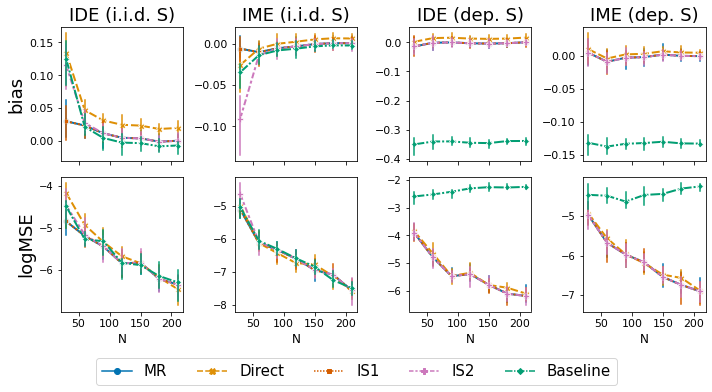

In [3]:
result_iid = summary(Error_iid, N_range = np.arange(1, 8) * 30, T_range = [50], absolute = False)
result_w_state = summary(Error_w_state, N_range = np.arange(1, 8) * 30, T_range = [50], absolute = False)

fig = plot(result_iid,result_w_state,x='N')